In [1]:
import pandas as pd

In [2]:
# Load the data from a CSV file
df = pd.read_csv('player_match_ratings.csv')

# Display the first few rows of the dataframe
print(df.head())

  competition        date                    match    team  pos pos_role  \
0   Euro 2016  10/06/2016  France - Romania, 2 - 1  France  Sub      Sub   
1   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   FW       FW   
2   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   DF       DC   
3   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   
4   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   

              player  goals  assists  shots_ontarget  ...  betweenness2goals  \
0    Anthony Martial      0        0               1  ...           0.000000   
1     Olivier Giroud      1        0               2  ...           0.050000   
2  Laurent Koscielny      0        0               0  ...           0.000000   
3       N'Golo Kante      0        1               0  ...           0.032258   
4         Paul Pogba      0        0               1  ...           0.000000   

   win  lost  is_home_team  minutesPlayed  game_duration  non_

In [3]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating (target mean)
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.2        # impact of opponent difficulty on expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent (difficulty>0.5) lowers expectation; easier raises it
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

# ...existing code...
def compute_ratings(pm,
                    K=K,
                    diff_impact=DIFF_IMPACT,
                    diff_update_amp=0.0,     # NEW: amplify updates by opponent level
                    diff_power=1.0,          # optional nonlinearity of difficulty term
                    keep_global_mean=True,
                    recenter_each_step=False):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    keep_global_mean:
        If True, enforce final (or stepwise) mean rating == BASE_NOTE.
    recenter_each_step:
        If True, re-centers after each date block. Else only one final shift.
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    def _diff_term(d):
        # centered, scaled to [-1, +1]; allow optional nonlinearity
        t = (float(d) - 0.5) * 2.0
        return np.sign(t) * (abs(t) ** diff_power)

    if recenter_each_step:
        for date, day_df in pm.groupby('date'):
            for row in day_df.itertuples(index=False):
                player = row.player
                # Seed an initial point at BASE_NOTE before the first match
                if player not in player_rating:
                    player_rating[player] = BASE_NOTE
                    seed_date = pd.to_datetime(row.date) - pd.Timedelta(microseconds=1)
                    history.append((seed_date, row.match, player, BASE_NOTE, np.nan, np.nan, BASE_NOTE))

                perf   = row.P
                w_min  = row.w_min
                diff   = 0.5 if pd.isna(row.difficulty) else row.difficulty
                match  = row.match
                R_old  = player_rating.get(player, BASE_NOTE)

                if pd.isna(perf):
                    history.append((row.date, match, player, R_old, np.nan, np.nan, R_old))
                    continue

                E = expected_performance(BASE_NOTE, diff, diff_impact)
                scale = max(0.0, 1.0 + diff_update_amp * _diff_term(diff))  # amplify by opponent level
                delta = K * w_min * scale * (perf - E)
                R_new = R_old + delta
                player_rating[player] = R_new
                history.append((row.date, match, player, R_old, perf, E, R_new))
            # ...existing code...
    else:
        for row in pm.itertuples(index=False):
            player = row.player
            date   = row.date
            match  = row.match

            # Seed an initial point at BASE_NOTE before the first match
            if player not in player_rating:
                player_rating[player] = BASE_NOTE
                seed_date = pd.to_datetime(date) - pd.Timedelta(microseconds=1)
                history.append((seed_date, match, player, BASE_NOTE, np.nan, np.nan, BASE_NOTE))

            perf   = row.P
            w_min  = row.w_min
            diff   = 0.5 if pd.isna(row.difficulty) else row.difficulty
            R_old  = player_rating.get(player, BASE_NOTE)

            if pd.isna(perf):
                history.append((date, match, player, R_old, np.nan, np.nan, R_old))
                continue

            E = expected_performance(BASE_NOTE, diff, diff_impact)
            scale = max(0.0, 1.0 + diff_update_amp * _diff_term(diff))  # amplify by opponent level
            delta = K * w_min * scale * (perf - E)
            R_new = R_old + delta
            player_rating[player] = R_new
            history.append((date, match, player, R_old, perf, E, R_new))

        # ...existing code...
# ...existing code...
        # ...existing code...
# ...existing code...

        # Final global recenter
        if keep_global_mean and player_rating:
            final_mean = np.mean(list(player_rating.values()))
            shift = BASE_NOTE - final_mean
            if abs(shift) > 1e-12:
                history = [(d,m,p,Rb+shift,P,E,Ra+shift) for (d,m,p,Rb,P,E,Ra) in history]
                for p in player_rating:
                    player_rating[p] += shift

    ratings_ts = pd.DataFrame(history,
                              columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date","match","player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty (scale opponent_ranking per competition)
max_rank_df = (pm0.groupby("competition", dropna=False)["opponent_ranking"]
                  .max().rename("max_rank").reset_index())
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average (ignores NaNs)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings (final mean preserved at BASE_NOTE)
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg, keep_global_mean=True, recenter_each_step=False)
ts_hum, fin_hum = compute_ratings(pm_hum, keep_global_mean=True, recenter_each_step=False)
ts_ai,  fin_ai  = compute_ratings(pm_ai,  keep_global_mean=True, recenter_each_step=False)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

Guardian (England) players in our data: 32; evaluation subset (played in PL 2017-18): 32

Best configuration:
  w_human=0.4  diff_impact=1.0  diff_update_amp=1.0  Spearman=0.612 on n=32


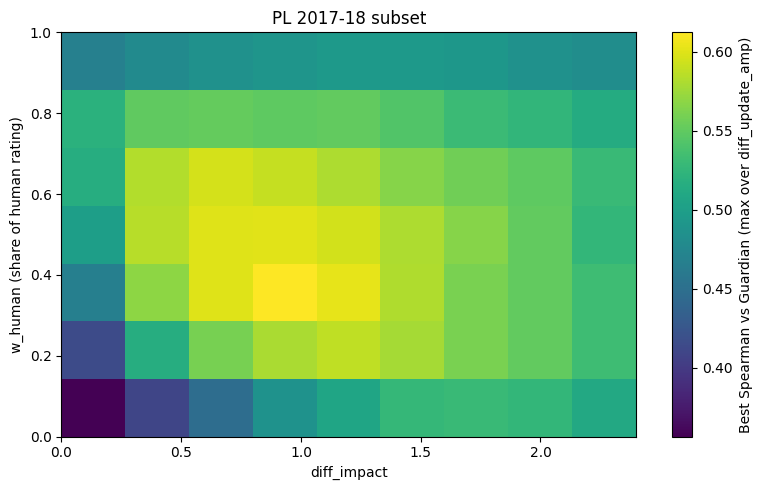

In [4]:
# Guardian overlap + grid search on diff_impact and human/non-human mixing
import pandas as pd, numpy as np, unicodedata, re
import matplotlib.pyplot as plt

# --- helpers ---
def norm_name(s):
    if pd.isna(s): return ""
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def spearman_from_rank_maps(a_map, b_map):
    keys = sorted(set(a_map) & set(b_map))
    if not keys: return np.nan, 0
    a = pd.Series([a_map[k] for k in keys], dtype=float)
    b = pd.Series([b_map[k] for k in keys], dtype=float)
    return a.corr(b, method="pearson"), len(keys)

def build_pm_mix(pm0, w_h):
    # weighted mix with NA‑robust fallback
    pm = pm0[["date","match","player","w_min","difficulty"]].copy()
    h = pm0["human_rating"]
    a = pm0["non_human_rating"]
    both = (~h.isna()) & (~a.isna())
    p = pd.Series(index=pm.index, dtype=float)
    p[both] = w_h * h[both] + (1 - w_h) * a[both]
    p[~both] = h.where(a.isna(), a)[~both]
    pm["P"] = p
    return pm

# --- load Guardian top 100 and keep England players present in our data ---
g = pd.read_csv("top100guardian.csv")
# find player name column
name_col = next((c for c in g.columns if c.lower() in ["player","name","player_name","full_name"]), None)
if name_col is None:
    raise ValueError("Cannot find a player name column in top100guardian.csv")

# attempt to detect "played in England"
eng_cols = [c for c in g.columns
            if any(k in c.lower() for k in ["league","club","team","competition","country"])
            and not any(k in c.lower() for k in ["nationality","citizen","birth"])]
g["_eng_flag"] = False
for c in eng_cols:
    vals = g[c].astype(str).str.lower()
    g["_eng_flag"] |= vals.str.contains("premier league|england|english premier", regex=True)

g_eng = g[g["_eng_flag"]].copy()
if g_eng.empty:
    print("Warning: no 'England' rows detected; using all rows as fallback.")
    g_eng = g.copy()

# guardian rank: use 'rank' column if present, else order
rank_col = next((c for c in g.columns if "rank" in c.lower() or "position" in c.lower()), None)
if rank_col is None:
    g_eng = g_eng.reset_index(drop=True)
    g_eng["guardian_rank"] = g_eng.index + 1
else:
    g_eng["guardian_rank"] = pd.to_numeric(g_eng[rank_col], errors="coerce")
    g_eng = g_eng.dropna(subset=["guardian_rank"])

g_eng["key"] = g_eng[name_col].apply(norm_name)

# our players + players who appeared in PL 2017-18
our_players = pd.Series(pm0["player"].unique(), name="player")
key_map = {p: norm_name(p) for p in our_players}
pm0["_key"] = pm0["player"].map(key_map)

players_in_pl = set(pm0.loc[pm0["competition"] == "Premier League 2017-18", "_key"].unique())

# restrict Guardian to names present in our data, and later to PL players for evaluation
guardian_present = g_eng[g_eng["key"].isin(set(pm0["_key"]))].copy()
guardian_present = guardian_present[["key","guardian_rank", name_col]].drop_duplicates()
guardian_rank_map_all = dict(zip(guardian_present["key"], guardian_present["guardian_rank"]))

eval_keys = sorted(set(guardian_present["key"]) & players_in_pl)
print(f"Guardian (England) players in our data: {len(guardian_present)}; "
      f"evaluation subset (played in PL 2017-18): {len(eval_keys)}")

if len(eval_keys) == 0:
    raise ValueError("No overlap between Guardian(England) and PL 2017-18 players in your data.")

# ...existing code...
# --- grid search settings ---
diff_values         = [0.0, 0.5, 0.75, 1.0, 1.2, 1.5, 1.8, 2.0, 2.4]
human_weights       = [0.0, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0]
diff_update_values  = [0.0, 0.25, 0.5, 0.75, 1.0]   # NEW: difficulty-based update amplification

rows = []
best = {"score": -1, "params": None, "final": None}

for w_h in human_weights:
    pm_mix = build_pm_mix(pm0, w_h)
    for dv in diff_values:
        for amp in diff_update_values:
            ts_tmp, fin_tmp = compute_ratings(pm_mix,
                                              K=K,
                                              diff_impact=dv,
                                              diff_update_amp=amp,
                                              keep_global_mean=True,
                                              recenter_each_step=False)
            fin_tmp = fin_tmp.sort_values("final_rating", ascending=False).reset_index(drop=True)
            fin_tmp["rank"] = fin_tmp.index + 1
            fin_tmp["_key"] = fin_tmp["player"].map(lambda x: key_map.get(x, norm_name(x)))
            our_rank_map = dict(zip(fin_tmp["_key"], fin_tmp["rank"]))

            guardian_rank_map = {k: guardian_rank_map_all[k] for k in eval_keys if k in guardian_rank_map_all}
            our_rank_map_eval = {k: our_rank_map[k] for k in eval_keys if k in our_rank_map}

            spearman, n_common = spearman_from_rank_maps(guardian_rank_map, our_rank_map_eval)
            top5 = fin_tmp.head(5)["player"].tolist()
            rows.append({
                "w_human": w_h,
                "diff_impact": dv,
                "diff_update_amp": amp,   # NEW
                "spearman": spearman,
                "n_eval": n_common,
                "top5": ", ".join(top5)
            })
            if pd.notna(spearman) and spearman > best["score"]:
                best = {"score": spearman, "params": (w_h, dv, amp), "final": fin_tmp.copy()}

results = pd.DataFrame(rows).sort_values(["spearman","n_eval"], ascending=[False, False]).reset_index(drop=True)
print("\nBest configuration:")
print(f"  w_human={best['params'][0]}  diff_impact={best['params'][1]}  diff_update_amp={best['params'][2]}  "
      f"Spearman={best['score']:.3f} on n={results.iloc[0]['n_eval']}")

# Heatmap: best score across diff_update_amp for each (w_human, diff_impact)
pivot = (results
         .groupby(["w_human","diff_impact"])["spearman"]
         .max()
         .unstack("diff_impact"))
plt.figure(figsize=(8,5))
im = plt.imshow(pivot.values, aspect="auto", origin="lower",
                extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()],
                cmap="viridis")
plt.colorbar(im, label="Best Spearman vs Guardian (max over diff_update_amp)")
plt.xlabel("diff_impact")
plt.ylabel("w_human (share of human rating)")
plt.title("PL 2017-18 subset")
plt.tight_layout()
plt.show()
# ...existing code...

Guardian players in our data (ENG or BUND): 37
  Evaluation PL 2017-18 overlap: 32 players
  Evaluation Bundesliga 2017-18 overlap: 6 players

Best configuration (combined):
  w_human=0.25  diff_impact=1.2  diff_update_amp=1.0  Score=0.528  n_total=38


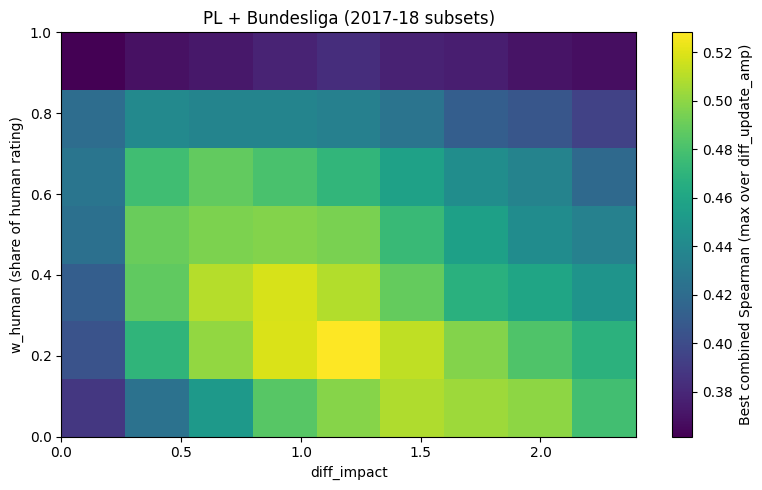

In [5]:
# ...existing code...
# Guardian overlap + grid search on diff_impact and human/non-human mixing (PL + Bundesliga)
import pandas as pd, numpy as np, unicodedata, re
import matplotlib.pyplot as plt

# --- helpers ---
def norm_name(s):
    if pd.isna(s): return ""
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def spearman_from_rank_maps(a_map, b_map):
    keys = sorted(set(a_map) & set(b_map))
    if not keys: return np.nan, 0
    a = pd.Series([a_map[k] for k in keys], dtype=float)
    b = pd.Series([b_map[k] for k in keys], dtype=float)
    # Pearson on ranks == Spearman
    return a.corr(b, method="pearson"), len(keys)

def build_pm_mix(pm0, w_h):
    # weighted mix with NA‑robust fallback
    pm = pm0[["date","match","player","w_min","difficulty"]].copy()
    h = pm0["human_rating"]
    a = pm0["non_human_rating"]
    both = (~h.isna()) & (~a.isna())
    p = pd.Series(index=pm.index, dtype=float)
    p[both] = w_h * h[both] + (1 - w_h) * a[both]
    p[~both] = h.where(a.isna(), a)[~both]
    pm["P"] = p
    return pm

# --- load Guardian top 100 and keep England or Bundesliga players present in our data ---
g = pd.read_csv("top100guardian.csv")

# find player name column
name_col = next((c for c in g.columns if c.lower() in ["player","name","player_name","full_name"]), None)
if name_col is None:
    raise ValueError("Cannot find a player name column in top100guardian.csv")

# attempt to detect league/country fields
eng_cols = [c for c in g.columns
            if any(k in c.lower() for k in ["league","club","team","competition","country"])
            and not any(k in c.lower() for k in ["nationality","citizen","birth"])]

# flags for England and Bundesliga
g["_eng_flag"] = False
g["_bund_flag"] = False
for c in eng_cols:
    vals = g[c].astype(str).str.lower()
    g["_eng_flag"]  |= vals.str.contains("premier league|england|english premier|epl", regex=True)
    g["_bund_flag"] |= vals.str.contains("bundesliga|germany|german bundesliga|1\\. bundesliga", regex=True)

# keep players who played in England OR Bundesliga
g_sel = g[g["_eng_flag"] | g["_bund_flag"]].copy()
if g_sel.empty:
    print("Warning: no 'England' or 'Bundesliga' rows detected; using all rows as fallback.")
    g_sel = g.copy()

# guardian rank: use 'rank' column if present, else order
rank_col = next((c for c in g.columns if "rank" in c.lower() or "position" in c.lower()), None)
if rank_col is None:
    g_sel = g_sel.reset_index(drop=True)
    g_sel["guardian_rank"] = g_sel.index + 1
else:
    g_sel["guardian_rank"] = pd.to_numeric(g_sel[rank_col], errors="coerce")
    g_sel = g_sel.dropna(subset=["guardian_rank"])

g_sel["key"] = g_sel[name_col].apply(norm_name)

# our players + keys
our_players = pd.Series(pm0["player"].unique(), name="player")
key_map = {p: norm_name(p) for p in our_players}
pm0["_key"] = pm0["player"].map(key_map)

# Which of the Guardian(ENG or BUND) players are present in our data?
guardian_present = g_sel[g_sel["key"].isin(set(pm0["_key"]))].copy()
guardian_present = guardian_present[["key","guardian_rank", name_col]].drop_duplicates()
guardian_rank_map_all = dict(zip(guardian_present["key"], guardian_present["guardian_rank"]))

# Evaluation subsets: PL and Bundesliga players who have at least 1 match in our data
players_in_pl  = set(pm0.loc[pm0["competition"] == "Premier League 2017-18", "_key"].unique())
players_in_bl  = set(pm0.loc[pm0["competition"] == "Bundesliga 2017-18",      "_key"].unique())

eval_pl = sorted(set(guardian_present["key"]) & players_in_pl)
eval_bl = sorted(set(guardian_present["key"]) & players_in_bl)

print(f"Guardian players in our data (ENG or BUND): {len(guardian_present)}")
print(f"  Evaluation PL 2017-18 overlap: {len(eval_pl)} players")
print(f"  Evaluation Bundesliga 2017-18 overlap: {len(eval_bl)} players")

if len(eval_pl) == 0 and len(eval_bl) == 0:
    raise ValueError("No overlap between Guardian and PL/Bundesliga 2017-18 players in your data.")

# ...existing code...
# --- grid search settings ---
diff_values         = [0.0, 0.5, 0.75, 1.0, 1.2, 1.5, 1.8, 2.0, 2.4]
human_weights       = [0.0, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0]
diff_update_values  = [0.0, 0.25, 0.5, 0.75, 1.0]   # NEW

rows = []
best_comb = {"score": -np.inf, "params": None, "final": None}
best_pl   = {"score": -np.inf, "params": None, "final": None}
best_bl   = {"score": -np.inf, "params": None, "final": None}

for w_h in human_weights:
    pm_mix = build_pm_mix(pm0, w_h)
    for dv in diff_values:
        for amp in diff_update_values:
            ts_tmp, fin_tmp = compute_ratings(pm_mix,
                                              K=K,
                                              diff_impact=dv,
                                              diff_update_amp=amp,  # NEW
                                              keep_global_mean=True,
                                              recenter_each_step=False)
            fin_tmp = fin_tmp.sort_values("final_rating", ascending=False).reset_index(drop=True)
            fin_tmp["rank"] = fin_tmp.index + 1
            fin_tmp["_key"] = fin_tmp["player"].map(lambda x: key_map.get(x, norm_name(x)))
            our_rank_map = dict(zip(fin_tmp["_key"], fin_tmp["rank"]))

            g_map = guardian_rank_map_all

            our_pl = {k: our_rank_map[k] for k in eval_pl if k in our_rank_map}
            spearman_pl, n_pl = spearman_from_rank_maps({k: g_map[k] for k in eval_pl if k in g_map}, our_pl)

            our_bl = {k: our_rank_map[k] for k in eval_bl if k in our_rank_map}
            spearman_bl, n_bl = spearman_from_rank_maps({k: g_map[k] for k in eval_bl if k in g_map}, our_bl)

            n_tot = (n_pl or 0) + (n_bl or 0)
            score_comb = np.nan
            if n_tot > 0:
                wpl = (n_pl or 0) / n_tot
                wbl = (n_bl or 0) / n_tot
                score_comb = (0 if pd.isna(spearman_pl) else wpl * spearman_pl) + \
                             (0 if pd.isna(spearman_bl) else wbl * spearman_bl)

            top5 = fin_tmp.head(5)["player"].tolist()
            rows.append({
                "w_human": w_h,
                "diff_impact": dv,
                "diff_update_amp": amp,   # NEW
                "spearman_PL": spearman_pl, "n_PL": n_pl,
                "spearman_BL": spearman_bl, "n_BL": n_bl,
                "score_combined": score_comb, "n_total": n_tot,
                "top5": ", ".join(top5)
            })

            if n_tot > 0 and pd.notna(score_comb) and score_comb > best_comb["score"]:
                best_comb = {"score": score_comb, "params": (w_h, dv, amp), "final": fin_tmp.copy()}
            if (n_pl or 0) > 0 and pd.notna(spearman_pl) and spearman_pl > best_pl["score"]:
                best_pl = {"score": spearman_pl, "params": (w_h, dv, amp), "final": fin_tmp.copy()}
            if (n_bl or 0) > 0 and pd.notna(spearman_bl) and spearman_bl > best_bl["score"]:
                best_bl = {"score": spearman_bl, "params": (w_h, dv, amp), "final": fin_tmp.copy()}

results = pd.DataFrame(rows).sort_values(
    ["score_combined","n_total","spearman_PL","spearman_BL"], ascending=[False, False, False, False]
).reset_index(drop=True)

print("\nBest configuration (combined):")
print(f"  w_human={best_comb['params'][0]}  diff_impact={best_comb['params'][1]}  diff_update_amp={best_comb['params'][2]}  "
      f"Score={best_comb['score']:.3f}  n_total={results.iloc[0]['n_total']}")

# Heatmap: best score across diff_update_amp for each (w_human, diff_impact)
pivot = (results
         .groupby(["w_human","diff_impact"])["score_combined"]
         .max()
         .unstack("diff_impact"))
plt.figure(figsize=(8,5))
im = plt.imshow(pivot.values, aspect="auto", origin="lower",
                extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()],
                cmap="viridis")
plt.colorbar(im, label="Best combined Spearman (max over diff_update_amp)")
plt.xlabel("diff_impact")
plt.ylabel("w_human (share of human rating)")
plt.title("PL + Bundesliga (2017-18 subsets)")
plt.tight_layout()
plt.show()
# ...existing code...

In [6]:
# ...existing code...
# Apply best grid-search result to the model and export tuned ratings

# 1) Read best params from the previous grid-search if available; else use the shown best
if 'best_comb' in globals() and best_comb.get('params') is not None:
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best_comb['params']
elif 'best' in globals() and best.get('params') is not None:
    # fallback to PL-only search if that's what you ran last
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best['params']
else:
    # fallback to values reported in your plot
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = 0.25, 1.2, 1.0

print(f"Using tuned params -> w_human={SELECTED_W_HUMAN}, diff_impact={SELECTED_DIFF_IMPACT}, "
      f"diff_update_amp={SELECTED_DIFF_UPDATE_AMP}")

# 2) Build the mixed-performance dataset with NA-robust fallback
pm_best = pm0[["date","match","player","w_min","difficulty"]].copy()
h = pm0["human_rating"]
a = pm0["non_human_rating"]
both = (~h.isna()) & (~a.isna())
P = pd.Series(index=pm_best.index, dtype=float)
P[both]   = SELECTED_W_HUMAN * h[both] + (1.0 - SELECTED_W_HUMAN) * a[both]
P[~both]  = h.where(a.isna(), a)[~both]  # if only one source present, use it
pm_best["P"] = P

# 3) Compute tuned ratings with opponent-level update amplification
ts_tuned, fin_tuned = compute_ratings(
    pm_best,
    K=K,
    diff_impact=SELECTED_DIFF_IMPACT,
    diff_update_amp=SELECTED_DIFF_UPDATE_AMP,
    keep_global_mean=True,
    recenter_each_step=False
)

# 4) Save and preview results
ts_tuned["system"] = "tuned"
fin_tuned = fin_tuned.sort_values("final_rating", ascending=False).reset_index(drop=True)

ts_tuned.to_csv("ratings_timeseries_tuned.csv", index=False)
fin_tuned.to_csv("final_ratings_tuned.csv", index=False)

print("Saved final_ratings_tuned.csv and ratings_timeseries_tuned.csv")
print("Global mean (tuned) final rating:", round(fin_tuned["final_rating"].mean(), 6))
print("\nTop 10 (tuned):")
print(fin_tuned.head(10)[["player","final_rating"]])
# ...existing code...

Using tuned params -> w_human=0.25, diff_impact=1.2, diff_update_amp=1.0
Saved final_ratings_tuned.csv and ratings_timeseries_tuned.csv
Global mean (tuned) final rating: 6.926722

Top 10 (tuned):
              player  final_rating
0    Kevin De Bruyne     23.734262
1        Eden Hazard     18.706397
2         Harry Kane     17.087126
3      Mohamed Salah     17.036166
4  Christian Eriksen     16.087676
5         Leroy Sane     15.590409
6         Paul Pogba     14.477379
7     Jan Vertonghen     14.299808
8      Harry Maguire     13.935246
9      Sergio Aguero     13.889334


In [7]:
# ...existing code...
# Save combined: tuned + human + non-human (final ratings and time series)

# Sanity checks
needed_vars = ["fin_tuned","fin_hum","fin_ai","ts_tuned","ts_hum","ts_ai"]
missing = [v for v in needed_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing in memory: {missing}. Run previous cells first.")

# Ensure proper column names
fin_tuned_named = fin_tuned[["player","final_rating"]].rename(columns={"final_rating":"final_rating_tuned"})
if "final_rating_human" not in fin_hum.columns and "final_rating" in fin_hum.columns:
    fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
if "final_rating_ai" not in fin_ai.columns and "final_rating" in fin_ai.columns:
    fin_ai = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

# Merge final ratings
final_tha = (fin_tuned_named
             .merge(fin_hum[["player","final_rating_human"]], on="player", how="outer")
             .merge(fin_ai[["player","final_rating_ai"]], on="player", how="outer")
             .sort_values("final_rating_tuned", ascending=False))
final_tha.to_csv("final_ratings_tuned_human_ai.csv", index=False)

# Stack time series
if "system" not in ts_hum.columns: ts_hum["system"] = "human"
if "system" not in ts_ai.columns:  ts_ai["system"]  = "ai"
if "system" not in ts_tuned.columns: ts_tuned["system"] = "tuned"

ts_tha = (pd.concat([ts_tuned, ts_hum, ts_ai], ignore_index=True)
            .sort_values(["date","system","player"])
            .reset_index(drop=True))
ts_tha.to_csv("ratings_timeseries_tuned_human_ai.csv", index=False)

print("Saved:")
print("  final_ratings_tuned_human_ai.csv")
print("  ratings_timeseries_tuned_human_ai.csv")
# ...existing code...

Saved:
  final_ratings_tuned_human_ai.csv
  ratings_timeseries_tuned_human_ai.csv


In [8]:
# ...existing code...
# Diagnose the starting point and global shift applied by recentering
import numpy as np
assert 'ts_tuned' in globals()

first_rows = (ts_tuned.sort_values(['date','match'])
              .groupby('player', as_index=False)
              .first())

start_value = float(first_rows['rating_after'].iloc[0])
shift_applied = start_value - BASE_NOTE

print(f"Start value = {start_value:.6f}")
print(f"= BASE_NOTE ({BASE_NOTE:.6f}) + shift ({shift_applied:+.6f})")
# ...existing code...

Start value = 3.238199
= BASE_NOTE (6.926722) + shift (-3.688523)


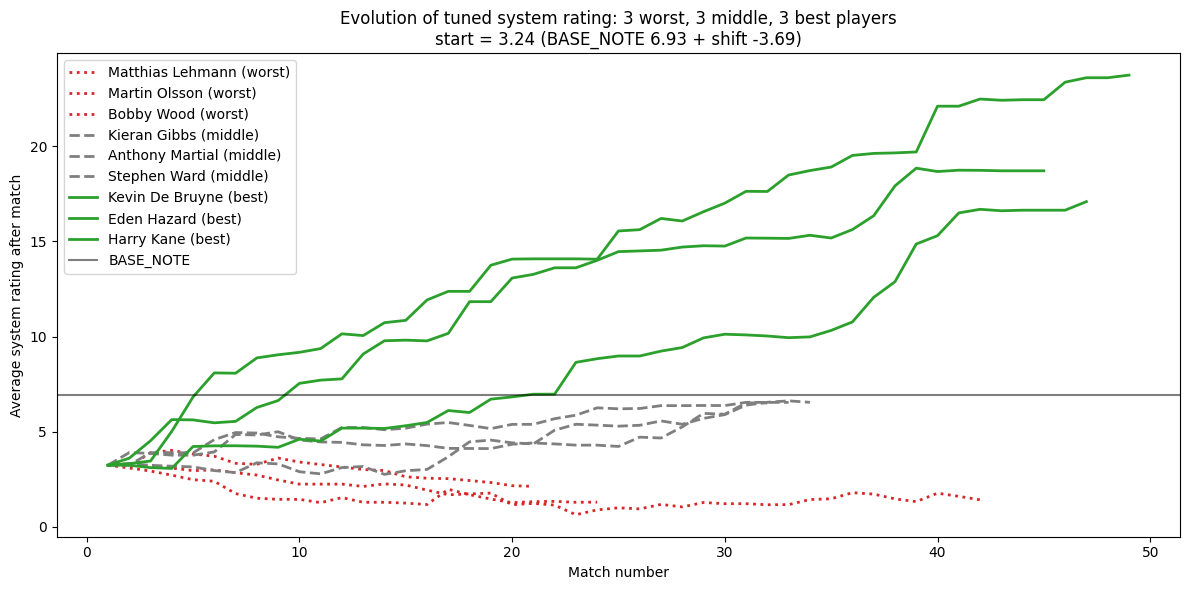

In [9]:
# ...existing code...
# Plot: Evolution du rating du système "tuned" (3 pires, 3 milieux, 3 meilleurs)
import matplotlib.pyplot as plt

assert 'ts_tuned' in globals() and 'fin_tuned' in globals(), "Exécuter d'abord le calcul du système tuned."

n = 3  # nombre de joueurs par groupe

best_players  = fin_tuned.head(n)['player'].tolist()
worst_players = fin_tuned.tail(n)['player'].tolist()
mid_start = max(0, len(fin_tuned)//2 - n//2)
mid_players  = fin_tuned.iloc[mid_start:mid_start+n]['player'].tolist()

def plot_group(players, style, color, suffix):
    for p in players:
        dfp = (ts_tuned[ts_tuned['player'] == p]
               .sort_values(['date','match'])
               .reset_index(drop=True))
        y = dfp['rating_after'].to_numpy()
        x = range(1, len(y)+1)
        plt.plot(x, y, linestyle=style, color=color, linewidth=2, label=f"{p} ({suffix})")

plt.figure(figsize=(12,6))
plot_group(worst_players, ':',  '#d62728', 'worst')
plot_group(mid_players,   '--', '#7f7f7f', 'middle')
plot_group(best_players,  '-',  '#2ca02c', 'best')

# ...existing code...
plt.axhline(BASE_NOTE, color='k', alpha=0.5, lw=1.5, label='BASE_NOTE')
plt.title(f"Evolution of tuned system rating: 3 worst, 3 middle, 3 best players\n"
          f"start = {start_value:.2f} (BASE_NOTE {BASE_NOTE:.2f} + shift {shift_applied:+.2f})")
# ...existing code...
plt.xlabel("Match number")
plt.ylabel("Average system rating after match")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
# ...existing code...

In [10]:
# ...existing code...
# Top 10 players per system: tuned, human-only, non-human-only
import pandas as pd, numpy as np

def _top10(df, col):
    return (df[['player', col]]
            .dropna()
            .sort_values(col, ascending=False)
            .head(10)
            .reset_index(drop=True)
            .assign(rank=lambda x: x.index + 1)
            .rename(columns={col: 'final_rating'}))

systems = []

# tuned
if 'fin_tuned' in globals():
    col_tuned = 'final_rating_tuned' if 'final_rating_tuned' in fin_tuned.columns else 'final_rating'
    systems.append(('tuned', _top10(fin_tuned, col_tuned)))

# human
if 'fin_hum' in globals():
    col_h = 'final_rating_human' if 'final_rating_human' in fin_hum.columns else 'final_rating'
    systems.append(('human', _top10(fin_hum, col_h)))

# non-human (AI)
if 'fin_ai' in globals():
    col_ai = 'final_rating_ai' if 'final_rating_ai' in fin_ai.columns else 'final_rating'
    systems.append(('ai', _top10(fin_ai, col_ai)))

# print and save
all_top = []
for name, df_top in systems:
    print(f"\nTop 10 - {name}")
    print(df_top[['rank', 'player', 'final_rating']])
    df_top_out = df_top.copy()
    df_top_out.insert(0, 'system', name)
    all_top.append(df_top_out)

if all_top:
    top10_by_system = pd.concat(all_top, ignore_index=True)
    top10_by_system.to_csv('top10_by_system.csv', index=False)
    print("\nSaved top10_by_system.csv")
else:
    print("No systems found. Run the previous cells first.")
# ...existing code...


Top 10 - tuned
   rank             player  final_rating
0     1    Kevin De Bruyne     23.734262
1     2        Eden Hazard     18.706397
2     3         Harry Kane     17.087126
3     4      Mohamed Salah     17.036166
4     5  Christian Eriksen     16.087676
5     6         Leroy Sane     15.590409
6     7         Paul Pogba     14.477379
7     8     Jan Vertonghen     14.299808
8     9      Harry Maguire     13.935246
9    10      Sergio Aguero     13.889334

Top 10 - human
   rank           player  final_rating
0     1  Kevin De Bruyne     23.259992
1     2    Mohamed Salah     16.965888
2     3      David Silva     16.102159
3     4       Leroy Sane     16.029852
4     5  Raheem Sterling     15.497754
5     6      Eden Hazard     15.272883
6     7    Jiri Pavlenka     14.866457
7     8    Sergio Aguero     14.435520
8     9    Wilfried Zaha     14.162392
9    10    Koen Casteels     13.912382

Top 10 - ai
   rank             player  final_rating
0     1    Kevin De Bruyne     20.